## ORL-8 Tradeoff between model and rule based rewards

**Goal:** Investigate trade-off between rules-based and model-based RL?

**Background**: Popular current post-training techniques use RL with a combination of rule-based and model-based rewards (see DeepSeek V3, R1). Reasoning-focussed models (DeepSeek-R1-Zero) heavily leverage the former, claiming to produce a model which ‘excels in reasoning while prioritizing helpfulness and harmlessness’. The implication is that the hard, rule-based (often solely outcome-based) rewards facilitate reasoning prowess, whilst model-based assessments (evaluating outcome and prior reasoning) keep the model on track from a preference alignment perspective.

**Value:** 

- does optimizing over rule-based AND model -based rewards impact the performance on rule-based metrics compared to using only rule-based reward models
- can incorporation of uncertainty in model-based rewards lead to more efficient alignment

**Deliverables:**

- training code
- graphs of performance / characteristic over training schedule

**Stakeholders:**

**Blockers:**

**Opportunities:**


**Experimental Plan**

1. Find paper confirming that RL with rule-based rewards can improve performance of a ~8B language model on a maths-like task (verifiable answers)
2. Reproduce ‘performance’ curve over training for fixed compute budget
3. Assess capability wrt some looser characteristic (not as easily verifiable, which could be assessed with a model-based reward). E.g. language mixing, helpfuless, harmlessness
    1. Assess characteristic curve over same training curve in (2)
4. Rerun training from (2), this time including both rule based reward and model-based reward
    1. Plot performance curve - presume slower /  lower than first time
    2. Plot characteristic curve - presume higher / faster than (3)
5. Rerun (4), but this time incorporate reward reward model uncertainty
    1. Plot performance curve - hope for at least as good as 4a
    2. Plot characteristic curve - hope for higher / faster than 4b

Reward model = policy model (’self rewarding’), most simple implementation

Performance = accuracy on held out mathsy test dataset

Characteristic = ‘reward’ on held out mathsy test dataset according to yuge LLM

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import lm_eval
from lm_eval.models import huggingface
from lm_eval.tasks import gsm8k
from unsloth import FastLanguageModel
import numpy as np
from typing import List, Tuple, Union, Optional
from lm_eval.api.model import LM
from lm_eval.loggers import WandbLogger
from transformers import PreTrainedModel, PreTrainedTokenizer
import wandb # for logging
from lm_eval import evaluator
from unsloth import FastLanguageModel, PatchFastRL
import time

sns.set_theme()
wandb.login()
# For notebooks, use the current working directory instead of __file__
notebook_path = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.join(notebook_path, '..')))

from src.data_loader import get_gsm8k_questions
from src.models import load_model as load_unsloth_model

/home/worc6607/Projects/uncertainty-aware-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-25 18:05:59,886	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: ed-phillips (ed-phillips-university-of-oxford) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## 1-2: Reproduce performance curve over training for fixed budget

In [2]:
# ran initial experiments with unsloth, checkout training performance

# path to results
path_to_logs = "../outputs/checkpoint-500/trainer_state.json"
logs = pd.DataFrame(json.load(open(path_to_logs, "r"))["log_history"])

In [3]:
logs

,completion_length,epoch,grad_norm,kl,learning_rate,loss,reward,reward_std,rewards/correctness_reward_func,rewards/int_reward_func,rewards/soft_format_reward_func,rewards/strict_format_reward_func,rewards/xmlcount_reward_func,step
0,196.125,0.000134,0.379657,0.000000,1.000000e-07,0.0000,0.007375,0.176088,0.00,0.0000,0.0,0.0000,0.007375,1
1,200.000,0.000268,0.345205,0.000000,2.000000e-07,-0.0000,0.041250,0.236881,0.00,0.0000,0.0,0.0000,0.041250,2
2,200.000,0.000401,0.000950,0.000231,3.000000e-07,0.0000,0.125000,0.000000,0.00,0.0000,0.0,0.0000,0.125000,3
3,200.000,0.000535,0.530846,0.000387,4.000000e-07,0.0000,0.050250,0.211425,0.00,0.0000,0.0,0.0000,0.050250,4
4,192.500,0.000669,0.281017,0.000452,5.000000e-07,0.0000,-0.076500,0.149744,0.00,0.0000,0.0,0.0000,-0.076500,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,95.625,0.066372,1.185631,0.201734,9.747124e-10,0.0081,3.437500,0.176777,2.00,0.5000,0.0,0.4375,0.500000,496
496,178.875,0.066506,0.298099,0.068723,5.482913e-10,0.0027,2.028375,1.354017,1.25,0.4375,0.0,0.0625,0.278375,497
497,180.750,0.066640,0.328639,0.099630,2.436900e-10,0.0040,1.703125,1.198841,0.50,0.4375,0.0,0.3125,0.453125,498
498,130.875,0.066774,0.318764,0.165319,6.092324e-11,0.0066,3.015625,1.181021,1.75,0.4375,0.0,0.3750,0.453125,499


/tmp/ipykernel_1534923/2876061727.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


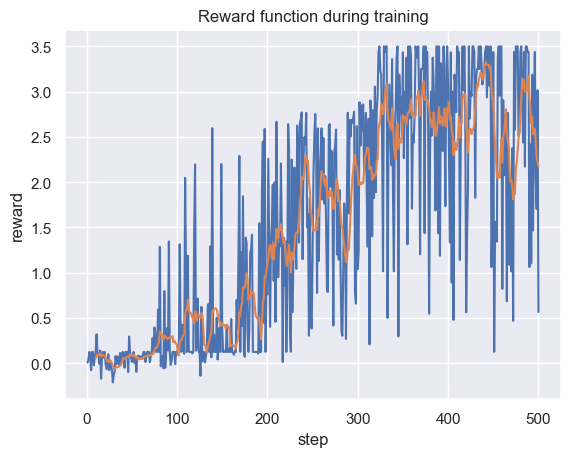

In [4]:
# plot reward function during training
fig, ax = plt.subplots()
ax.plot(logs['step'], logs["reward"])
ax.set(xlabel='step', ylabel='reward',
       title='Reward function during training')

# plot smoothed rewards on same axis
smoothed = logs["reward"].rolling(window=10).mean()
ax.plot(logs['step'], smoothed, label="smoothed")

fig.show()

In [5]:
# check performance on gsm test dataset before and after training
dataset = get_gsm8k_questions()
dataset

Dataset({
    features: ['question', 'answer', 'prompt'],
    num_rows: 7473
})

In [6]:
test_dataset = get_gsm8k_questions(split="test")
test_dataset

Dataset({
    features: ['question', 'answer', 'prompt'],
    num_rows: 1319
})

In [7]:
import wandb
import numpy as np
from tqdm import tqdm

class UnslothLM(LM):
    """Custom LM class for Unsloth models that implements the lm-eval-harness interface directly."""
    
    def __init__(
        self, 
        model: PreTrainedModel, 
        tokenizer: PreTrainedTokenizer,
        batch_size: int = 1,
        max_length: int = 1024,
        device: Optional[str] = None,
        log_to_wandb: bool = False,
        wandb_project: str = "lm-eval",
        wandb_run_name: str = None,
        verbose: bool = False,
        with_lora: bool = False,
        lora_path: str = None,
    ):
        """Initialize the UnslothLM wrapper."""
        super().__init__()
        
        self.model = model
        self.tokenizer = tokenizer
        self.verbose = verbose
        self.with_lora = with_lora
        self.lora_path = lora_path
        
        # Ensure tokenizer has necessary special tokens
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
            
        # Set device for inference
        self.device = device or ("cuda" if torch.cuda.is_available() else "cpu")
        if self.device != "cpu":
            self.model = self.model.to(self.device)
            
        self.batch_size = batch_size
        self.max_length = max_length
        
        # Initialize W&B logging if requested
        self.log_to_wandb = log_to_wandb
        if log_to_wandb:
            wandb.init(
                project=wandb_project,
                name=wandb_run_name,
                config={
                    "model_name": model.__class__.__name__,
                    "batch_size": batch_size,
                    "max_length": max_length,
                    "device": self.device
                }
            )
            self.generation_count = 0
            self.ll_count = 0

    @property
    def eot_token_id(self):
        # Return the end-of-text token ID for the model
        return self.tokenizer.eos_token_id
    
    @property
    def max_length(self):
        return self._max_length
    
    @max_length.setter
    def max_length(self, value):
        self._max_length = value
    
    @property
    def batch_size(self):
        return self._batch_size
    
    @batch_size.setter
    def batch_size(self, value):
        self._batch_size = value
    
    @property
    def device(self):
        return self._device
    
    @device.setter
    def device(self, value):
        self._device = value
    
    def loglikelihood(self, requests):
        """Calculate log-likelihood for each request."""
        results = []
        
        # Create a progress bar if verbose
        requests_iter = tqdm(requests, desc="Processing loglikelihoods") if self.verbose else requests
        
        for request in requests_iter:
            # Handle different request formats (tuple or Instance)
            if hasattr(request, 'args'):
                # This is an Instance object from lm-eval-harness
                context, continuation = request.args
            else:
                # This is a direct (context, continuation) tuple
                context, continuation = request
                
            # Tokenize with and without the continuation
            context_enc = self.tokenizer.encode(context, return_tensors="pt").to(self.device)
            
            # Get full sequence with continuation
            full_enc = self.tokenizer.encode(context + continuation, return_tensors="pt").to(self.device)
            
            # Get model outputs
            with torch.no_grad():
                outputs = self.model(full_enc)
                logits = outputs.logits
            
            # Extract logits for continuation tokens
            context_length = context_enc.shape[1]
            
            # Handle edge case where context length is too long
            if context_length >= len(full_enc[0]):
                # Just predict one token from the last context token
                continuation_logits = logits[0, -2:-1]
                continuation_ids = full_enc[0, -1:]
            else:
                continuation_logits = logits[0, context_length-1:-1]
                continuation_ids = full_enc[0, context_length:]
            
            # Calculate log likelihood
            log_probs = torch.log_softmax(continuation_logits, dim=-1)
            token_log_probs = torch.gather(log_probs, 1, continuation_ids.unsqueeze(-1)).squeeze(-1)
            seq_log_prob = token_log_probs.sum().item()
            
            # Check if continuation is the greedy prediction
            greedy_tokens = torch.argmax(continuation_logits, dim=-1)
            is_greedy = torch.all(greedy_tokens == continuation_ids).item()
            
            # Log to W&B if enabled
            if self.log_to_wandb:
                self.ll_count += 1
                wandb.log({
                    "ll_seq_log_prob": seq_log_prob,
                    "ll_is_greedy": float(is_greedy),
                    "ll_context_length": context_length,
                    "ll_continuation_length": len(continuation_ids),
                    "ll_step": self.ll_count
                })
                
                # Sample logging for inspection
                if self.ll_count % 50 == 0:  # Log a sample every 50 requests
                    wandb.log({
                        f"ll_sample_{self.ll_count}_context": context[:500],  # Truncate long contexts
                        f"ll_sample_{self.ll_count}_continuation": continuation[:500]
                    })
            
            results.append((seq_log_prob, is_greedy))
        
        return results
    
    def loglikelihood_rolling(self, requests):
        """Calculate rolling log-likelihood for each request."""
        results = []
        
        # Create a progress bar if verbose
        requests_iter = tqdm(requests, desc="Processing rolling loglikelihoods") if self.verbose else requests
        
        for request in requests_iter:
            # Handle different request formats (tuple or Instance)
            if hasattr(request, 'args'):
                # This is an Instance object from lm-eval-harness
                context, continuation = request.args
            else:
                # This is a direct (context, continuation) tuple
                context, continuation = request
                
            # Tokenize the combined text
            full_text = context + continuation
            full_enc = self.tokenizer.encode(full_text, return_tensors="pt").to(self.device)
            
            # Tokenize just the context to find its length
            context_enc = self.tokenizer.encode(context, return_tensors="pt").to(self.device)
            context_length = context_enc.shape[1]
            
            # Get model outputs for the entire sequence
            with torch.no_grad():
                outputs = self.model(full_enc)
                logits = outputs.logits
            
            # Extract logits for continuation tokens
            if context_length >= len(full_enc[0]):
                # Just predict one token from the last context token
                continuation_logits = logits[0, -2:-1]
                continuation_ids = full_enc[0, -1:]
            else:
                continuation_logits = logits[0, context_length-1:-1]
                continuation_ids = full_enc[0, context_length:]
            
            # Calculate log probs and check if prediction is greedy
            log_probs = torch.log_softmax(continuation_logits, dim=-1)
            token_log_probs = torch.gather(log_probs, 1, continuation_ids.unsqueeze(-1)).squeeze(-1)
            
            # Sum up the token log probs to get sequence log prob
            seq_log_prob = token_log_probs.sum().item()
            
            # Check if the prediction is greedy
            greedy_tokens = torch.argmax(continuation_logits, dim=-1)
            is_greedy = torch.all(greedy_tokens == continuation_ids).item()
            
            # Log to W&B if enabled
            if self.log_to_wandb:
                self.ll_count += 1
                wandb.log({
                    "llr_seq_log_prob": seq_log_prob,
                    "llr_is_greedy": float(is_greedy),
                    "llr_token_log_probs_mean": token_log_probs.mean().item(),
                    "llr_token_log_probs_std": token_log_probs.std().item() if len(token_log_probs) > 1 else 0,
                    "llr_step": self.ll_count
                })
            
            results.append((seq_log_prob, is_greedy))
        
        return results
    
    def greedy_until(self, requests):
        """Complete the request with greedy sampling until a stopping criterion is met."""
        return self.generate_until(requests, do_sample=False)
    
    def generate_until(self, requests, do_sample=True, temperature=0.8, top_p=0.95):
        """
        Generate text using vLLM's fast_generate for faster sampling.
        This method replaces the slow token-by-token generation loop.
        """
        try:
            from vllm import SamplingParams
        except ImportError:
            raise ImportError("vLLM is not installed. Please install it with `pip install vllm`.")

        results = []
        sampling_params = SamplingParams(
            temperature=temperature,
            top_p=top_p,
            max_tokens=self.max_length,
        )
        
        # Create a progress bar if verbose
        requests_iter = tqdm(requests, desc="Generating text with vLLM") if self.verbose else requests
        
        for request in requests_iter:
            # Unpack the request. It can be either an object with .args or a (context, until) tuple.
            if hasattr(request, 'args'):
                context, until = request.args
            else:
                context, until = request
            
            # Ensure 'until' is a list of stop strings
            if isinstance(until, str):
                until = [until]
            
            # Prepare the prompt.
            # If your tokenizer supports a chat template, use it. Otherwise, fall back to the plain context.
            try:
                prompt = self.tokenizer.apply_chat_template(
                    [{"role": "user", "content": context}],
                    tokenize=False,
                    add_generation_prompt=True
                )
            except AttributeError:
                prompt = context
            
            # Use vLLM's fast_generate to produce output.
            lora_request = self.model.load_lora(self.lora_path) if self.with_lora else None
            outputs = self.model.fast_generate(prompt, sampling_params=sampling_params,
                                               lora_request=lora_request)
            generated_text = outputs[0].outputs[0].text
            
            # Truncate the generated text at the first occurrence of any stop string.
            for stop_string in until:
                if stop_string in generated_text:
                    generated_text = generated_text.split(stop_string)[0]
                    break
            
            # Optionally log details to W&B.
            if self.log_to_wandb:
                self.generation_count += 1
                wandb.log({
                    "gen_tokens_generated": len(generated_text.split()),
                    "gen_step": self.generation_count
                })
                # if self.generation_count % 10 == 0:
                #     wandb.log({
                #         f"gen_sample_{self.generation_count}_context": context[:500],
                #         f"gen_sample_{self.generation_count}_response": generated_text[:500]
                #     })
            
            if self.verbose:
                print("Context (truncated):", context[:100], "...")
                print("Generated:", generated_text)
                print("Stop criteria:", until)
                print("-" * 50)
                
            results.append(generated_text)
        
        return results

In [8]:
def test_model(model_dir="", tokenizer_dir="", model_name=None, log_to_wandb=True, wandb_project="lm-eval-gsm8k", wandb_run_name=None,
               with_lora=None, lora_path=None):
    """Function to test model against gsm8k"""
    

    # Generate a run name if not provided
    if wandb_run_name is None:
        if model_name:
            model_id = model_name.split('/')[-1]
            wandb_run_name = f"{model_id}-{time.strftime('%Y%m%d-%H%M%S')}"
        else:
            model_id = os.path.basename(model_dir)
            wandb_run_name = f"{model_id}-{time.strftime('%Y%m%d-%H%M%S')}"    
    
    # Apply the patch if not already applied
    try:
        PatchFastRL("GRPO", FastLanguageModel)
    except Exception as e:
        print(f"Note: Patch already applied or error: {e}")
    
    # Load model based on the provided parameters
    if model_name is None:
        # Import for standard HF model loading
        from transformers import AutoModelForCausalLM, AutoTokenizer
        
        # Load from directories
        model = AutoModelForCausalLM.from_pretrained(
            model_dir, 
            device_map="auto",
            # torch_dtype=torch.bfloat16 if torch.cuda.is_available() else torch.float32
        )
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_dir)
    else:    
        # Load using Unsloth's functions
        model, tokenizer = load_unsloth_model(model_name)
        # Convert to inference mode
        model = FastLanguageModel.for_inference(model)
    
    # Create our custom wrapper for lm-eval-harness with W&B logging
    print("Creating UnslothLM wrapper with W&B logging...")
    unsloth_lm = UnslothLM(
        model=model,
        tokenizer=tokenizer,
        batch_size=1,  # Adjust based on your GPU memory
        max_length=1024,  # Adjust as needed
        log_to_wandb=log_to_wandb,
        wandb_project=wandb_project,
        wandb_run_name=wandb_run_name,
        verbose=True,  # Enable verbose output
        with_lora=with_lora,
        lora_path=lora_path,
    )
    
    # Run the evaluation
    print("Starting evaluation on GSM8K...")
    results = evaluator.simple_evaluate(
        model=unsloth_lm,
        tasks=["gsm8k"],
        num_fewshot=0,  # The standard for GSM8K is 8-shot
        batch_size=1,
        device="cuda" if torch.cuda.is_available() else "cpu",
        log_samples=True
    )
    if log_to_wandb:
        wandb_logger = WandbLogger(
            # project="lm-eval-harness-integration", job_type="eval"
        )  # or empty if wandb.init(...) already called before
        wandb_logger.post_init(results)
        wandb_logger.log_eval_result()
        wandb_logger.log_eval_samples(results["samples"])  # if log_samples
    
    # # Print the results
    # print("\nEvaluation Results:")
    # results_table = evaluator.make_table(results)
    # print(results_table)
    
    # # Log final results to W&B
    # if log_to_wandb:
        
    #     # Extract the accuracy from results
    #     try:
    #         gsm8k_results = results["results"]["gsm8k"]
    #         for metric_name, metric_value in gsm8k_results.items():
    #             wandb.log({f"final_{metric_name}": metric_value})
            
    #         # Log the results table as text
    #         wandb.log({"results_table": wandb.Html(f"<pre>{results_table}</pre>")})
            
    #         # Close the W&B run
    #         wandb.finish()
    #     except Exception as e:
    #         print(f"Error logging final results to W&B: {e}")
    
    return results

In [9]:
# results = test_model(model_name="unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit")

In [10]:
# run for base model
# initial_results = test_model(model_name="unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit")

In [ ]:
# run for RL model
rl_results = test_model(model_name="unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit", with_lora=True, lora_path="../outputs/grpo_saved_lora")


INFO 02-25 18:06:06 __init__.py:207] Automatically detected platform cuda.
==((====))==  Unsloth 2025.2.12: Fast Qwen2 patching. Transformers: 4.48.3.
   \\   /|    GPU: NVIDIA RTX A4000. Max memory: 15.716 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu124. CUDA: 8.6. CUDA Toolkit: 12.4. Triton: 3.1.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: vLLM loading unsloth/qwen2.5-3b-instruct-unsloth-bnb-4bit with actual GPU utilization = 43.99%
Unsloth: Your GPU has CUDA compute capability 8.6 with VRAM = 15.72 GB.
Unsloth: Using conservativeness = 1.0. Chunked prefill tokens = 1024. Num Sequences = 192.
Unsloth: vLLM's KV Cache can use up to 4.5 GB. Also swap space = 2 GB.
INFO 02-25 18:06:13 config.py:549] This model supports multiple tasks: {'reward', 'classify', 'embed', 'score', 'generate'}. 

[W225 18:06:14.772917139 CUDAAllocatorConfig.h:28] Warning: expandable_segments not supported on this platform (function operator())


INFO 02-25 18:06:14 weight_utils.py:254] Using model weights format ['*.safetensors']


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.78it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.78it/s]

Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.62it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.62it/s]


INFO 02-25 18:06:16 model_runner.py:1115] Loading model weights took 2.2160 GB


INFO 02-25 18:06:16 punica_selector.py:18] Using PunicaWrapperGPU.
INFO 02-25 18:06:17 worker.py:267] Memory profiling takes 0.97 seconds
INFO 02-25 18:06:17 worker.py:267] the current vLLM instance can use total_gpu_memory (15.72GiB) x gpu_memory_utilization (0.44) = 6.91GiB
INFO 02-25 18:06:17 worker.py:267] model weights take 2.22GiB; non_torch_memory takes 0.04GiB; PyTorch activation peak memory takes 1.05GiB; the rest of the memory reserved for KV Cache is 3.61GiB.
INFO 02-25 18:06:17 executor_base.py:111] # cuda blocks: 6568, # CPU blocks: 3640
INFO 02-25 18:06:17 executor_base.py:116] Maximum concurrency for 1024 tokens per request: 102.62x
INFO 02-25 18:06:18 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utilization` or 

Capturing CUDA graph shapes: 100%|██████████| 27/27 [00:13<00:00,  2.01it/s]

INFO 02-25 18:06:31 model_runner.py:1562] Graph capturing finished in 13 secs, took 0.60 GiB
INFO 02-25 18:06:31 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 15.30 seconds



Unsloth 2025.2.12 patched 36 layers with 36 QKV layers, 36 O layers and 36 MLP layers.
Unsloth: Already have LoRA adapters! We shall skip this step.


Creating UnslothLM wrapper with W&B logging...


2025-02-25:18:06:35,427 INFO     [evaluator.py:164] Setting random seed to 0 | Setting numpy seed to 1234 | Setting torch manual seed to 1234 | Setting fewshot manual seed to 1234
2025-02-25:18:06:35,427 INFO     [evaluator.py:217] Using pre-initialized model


Starting evaluation on GSM8K...


2025-02-25:18:06:42,130 WARNING  [evaluator.py:270] Overwriting default num_fewshot of gsm8k from 5 to 0
2025-02-25:18:06:42,131 INFO     [task.py:415] Building contexts for gsm8k on rank 0...
100%|██████████| 1319/1319 [00:00<00:00, 5321.13it/s]
2025-02-25:18:06:42,393 INFO     [evaluator.py:496] Running generate_until requests
Generating text with vLLM:   0%|          | 0/1319 [00:00<?, ?it/s]


AttributeError: 'Qwen2ForCausalLM' object has no attribute 'load_lora'

In [12]:
rl_results

{'results': {'gsm8k': {'alias': 'gsm8k',
   'exact_match,strict-match': 0.0,
   'exact_match_stderr,strict-match': 0.0,
   'exact_match,flexible-extract': 0.686125852918878,
   'exact_match_stderr,flexible-extract': 0.0127826812510532}},
 'group_subtasks': {'gsm8k': []},
 'configs': {'gsm8k': {'task': 'gsm8k',
   'tag': ['math_word_problems'],
   'dataset_path': 'gsm8k',
   'dataset_name': 'main',
   'training_split': 'train',
   'test_split': 'test',
   'fewshot_split': 'train',
   'doc_to_text': 'Question: {{question}}\nAnswer:',
   'doc_to_target': '{{answer}}',
   'description': '',
   'target_delimiter': ' ',
   'fewshot_delimiter': '\n\n',
   'num_fewshot': 0,
   'metric_list': [{'metric': 'exact_match',
     'aggregation': 'mean',
     'higher_is_better': True,
     'ignore_case': True,
     'ignore_punctuation': False,
     'regexes_to_ignore': [',', '\\$', '(?s).*#### ', '\\.$']}],
   'output_type': 'generate_until',
   'generation_kwargs': {'until': ['Question:', '</s>', '<|i